# Coursera Capstone Final Project: Week 4

## Author: Pushkar Marathe

## Introduction

New York City (NYC) is largest city in the United States of America. According to the Wikipedia, the estimated (2019) population of NYC is 8.3 million [1], of which 3.1 million are immigrants [2]. It is one of the most ethnically diverse metropolises. A published article claims that there are about 710,000 Indians residing in NYC [3], which is about 9% of the total NYC population.

Among many other things, Indians are known for their love towards spicy food. In this final project, the best locations for eating as well as opening an Indian restaurant is explored throughout NYC.

## Specific Questions
1.	How many Indian restaurants are there in NYC and how are distributed along different neighborhoods/boroughs?

2.	What is the best location for Indian food in NYC?

3.	In which neighborhood, potential restaurant owner should invest to have best chance of success?

## Data

In order to answer above questions, the following data is needed:
1.	Geospatial information of NYC, including names of neighborhoods, boroughs as well as their latitude, longitude

2.	Details such as, name, ratings, of Indian restaurants in NYC.

Above data either be scrapped from internet and/or requested from Foresquare API using python.

## Methodology

1.	NYC geospatial data will be collected from https://cocl.us/new_york_dataset.

2.	Data of Indian restaurants will be requested by using Foresquare API.

3.	Collected data will be processed and exploratory analysis will be performed on the data.

4.	Cleaned data will be visualised using different python libraries.

## References

[1] https://en.wikipedia.org/wiki/New_York_City

[2] https://www1.nyc.gov/assets/immigrants/downloads/pdf/moia_annual_report_2018_final.pdf

[3] https://www.novacredit.com/resources/desis-in-new-york-a-guide-for-indian-newcomers-in-new-york-city/#:~:text=New%20York%20City%20houses%20one,Indian%20residents%20as%20of%202017.

# Coursera Capstone Final Project: Week 5

## Importing Libraries

In [103]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import folium
import json

from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans

## Foresquare Credentials

Below here credentials of Foresquare are given.

In [104]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DEJSCD4UW5OKOIFUL3DJIZRVCMC0P4KI4YN0SQLEM0MQ3U3A
CLIENT_SECRET:N2GE1JFRLPWE0JTYLQHLPXFC3YBE2T2SZYJJGHQRLZZX0JTR


## Collecting geospatial data of New York City

Function below extracts data of Boroughs, Neighborhoods, Latitude, Langitude from the url, and collects in a dataframe

In [105]:
def collecting_new_york_data():
    
    url='https://cocl.us/new_york_dataset'
    
    resp=requests.get(url).json()
    
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data


ny_data = collecting_new_york_data()
ny_data.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [106]:
ny_data.shape

(306, 4)

In [107]:
ny_data.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


## Collecting names and IDs of Indian restaraunts

In [108]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name


Below two functions gets venues

In [109]:
def get_venues(lat,lng):
    
    radius=500
    LIMIT=100
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [110]:
count=1
for row in ny_data.values.tolist():
   Borough, Neighborhood, Latitude, Longitude=row
   venues = get_venues(Latitude,Longitude)
   indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
   print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
   print(row)
   for resturant_detail in indian_restaurants.values.tolist():
       id, name , category=resturant_detail
       indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                               'Neighborhood': Neighborhood, 
                                               'ID': id,
                                               'Name' : name
                                              }, ignore_index=True)
   count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

In [111]:
# Saving restraunt data into a CSV file because of the limited number of calls on Foursquare

indian_rest_ny.to_csv(r'C:\Users\Dell\Documents\Courses\Applied Data Science Capstone\Week 4 & 5\indian_rest_ny_tocsv1.csv') 

Reading CSV file

In [112]:
indian_ny = pd.read_csv(r'C:\Users\Dell\Documents\Courses\Applied Data Science Capstone\Week 4 & 5\indian_rest_ny_tocsv1.csv')
indian_ny = indian_ny.drop(columns=['Unnamed: 0'])
indian_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights


In [113]:
indian_ny.tail()

,Borough,Neighborhood,ID,Name
60,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
61,Manhattan,Turtle Bay,4a5b660df964a52015bb1fe3,Amma
62,Manhattan,Turtle Bay,5ac3984ae57ca64be4dc6168,INDAY
63,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen
64,Brooklyn,Fulton Ferry,506a2625498e3c434686abbc,Asya Indian Restaurant


In [114]:
indian_ny.shape

(65, 4)

In [115]:
indian_ny.groupby('Borough')['ID'].count()

Borough
Bronx             3
Brooklyn         16
Manhattan        25
Queens           20
Staten Island     1
Name: ID, dtype: int64

## Indian restaraunts per borough

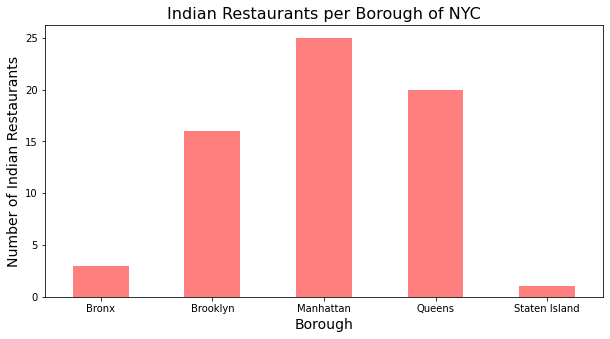

In [116]:
indian_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='red', alpha = 0.5)
plt.title('Indian Restaurants per Borough of NYC', fontsize = 16)
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('Number of Indian Restaurants', fontsize=14)
plt.xticks(rotation = 'horizontal')
plt.show()

## Indian restaraunts per neighborhood

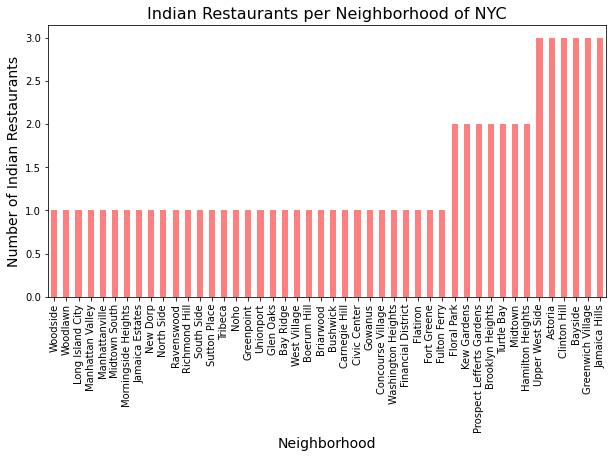

In [117]:
indian_ny.groupby('Neighborhood')['ID'].count().sort_values().plot.bar(figsize=(10,5), color='red', alpha = 0.5)
plt.title('Indian Restaurants per Neighborhood of NYC', fontsize = 16)
plt.xlabel('Neighborhood', fontsize = 14)
plt.ylabel('Number of Indian Restaurants', fontsize=14)
plt.xticks(rotation = '90')
plt.show()

## Collecting details of Indian restaraunts

Following two functions collect the venue details and put them in a dataframe.
1. ID
2. Name
3. Likes
4. Ratings
5. Tips

In [118]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [119]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5ff4c695f6bc1c09d33d1157'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
60,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.1,83
61,Manhattan,Turtle Bay,4a5b660df964a52015bb1fe3,Amma,101,7.7,67
62,Manhattan,Turtle Bay,5ac3984ae57ca64be4dc6168,INDAY,33,7.8,10
63,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen,681,8.3,132
64,Brooklyn,Fulton Ferry,506a2625498e3c434686abbc,Asya Indian Restaurant,55,6.7,27


In [120]:
# Saving restraunt data into a CSV file because of the limited number of calls on Foursquare

indian_rest_stats_ny.to_csv(r'C:\Users\Dell\Documents\Courses\Applied Data Science Capstone\Week 4 & 5\indian_rest_stats_ny.csv')

Reading CSV file

In [121]:
indian_stats_ny = pd.read_csv(r'C:\Users\Dell\Documents\Courses\Applied Data Science Capstone\Week 4 & 5\indian_rest_stats_ny.csv')
indian_stats_ny = indian_stats_ny.drop(columns=['Unnamed: 0'])
indian_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,35,6.9,18
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights,12,5.8,5


In [122]:
indian_stats_ny.shape

(65, 7)

Getting information about each feature and correcting their datatype

In [123]:
indian_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     int64  
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.7+ KB


In [124]:
indian_stats_ny['Likes'] = indian_stats_ny['Likes'].astype('float64')
indian_stats_ny['Tips'] = indian_stats_ny['Tips'].astype('float64')
indian_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     float64
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


### Exploratory Data Analysis

In [125]:
indian_stats_ny.describe()

,Likes,Rating,Tips
count,65.000000,65.000000,65.000000
mean,82.630769,7.116923,28.246154
std,158.237812,2.229039,45.766401
min,0.000000,0.000000,0.000000
25%,10.000000,6.900000,4.000000
50%,29.000000,7.800000,13.000000
75%,78.000000,8.300000,27.000000
max,831.000000,9.000000,255.000000


Indian resturant in NYC with maximum Likes

In [126]:
indian_stats_ny.iloc[indian_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                831
Rating                               8.6
Tips                                 255
Name: 24, dtype: object

Indian resturant in NYC with maximum Ratings

In [127]:
indian_stats_ny.iloc[indian_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                                 9
Tips                                 150
Name: 29, dtype: object

Indian resturant in NYC with maximum Tips/Comments

In [128]:
indian_stats_ny.iloc[indian_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                831
Rating                               8.6
Tips                                 255
Name: 24, dtype: object

#### Below are the top neighborhoods with the highest average ratings of Indian restaurants

In [129]:
ny_neighborhood_stats=indian_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(20)

,Neighborhood,Average Rating
38,Tribeca,9.000000
31,Noho,8.800000
19,Greenwich Village,8.633333
43,West Village,8.600000
28,Midtown South,8.600000
14,Fort Greene,8.500000
27,Midtown,8.450000
32,North Side,8.400000
36,South Side,8.400000
0,Astoria,8.366667


#### Below are the top boroughs with the highest average ratings of Indian restaurants

In [130]:
ny_borough_stats=indian_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
4,Staten Island,8.2000
2,Manhattan,8.1280
1,Brooklyn,7.4625
0,Bronx,7.0000
3,Queens,5.5400


## Average rating of Indian restaurants per borough

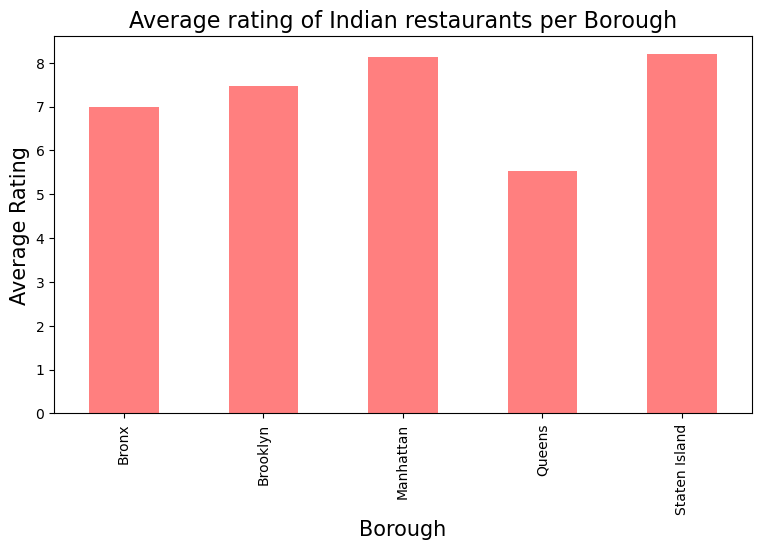

In [131]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian restaurants per Borough', fontsize = 16)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='red', alpha=0.5)
plt.show()

## Average rating of Indian restaurants per neighborhood

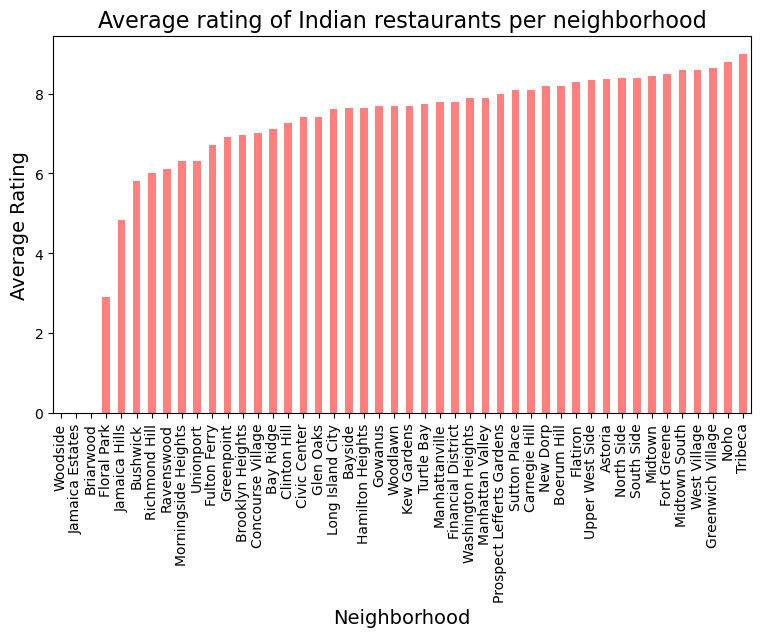

In [132]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian restaurants per neighborhood',fontsize = 16)
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('Average Rating', fontsize=14)
indian_stats_ny.groupby('Neighborhood').mean()['Rating'].sort_values().plot(kind='bar', color='red', alpha=0.5)
plt.show()

## Data visualization with neighborhoods having Average Rating of 7.5 or above

In [133]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>7.5].sort_values(by='Average Rating',ascending=False)
ny_neighborhood_stats.head(20)

,Neighborhood,Average Rating
38,Tribeca,9.000000
31,Noho,8.800000
19,Greenwich Village,8.633333
28,Midtown South,8.600000
43,West Village,8.600000
14,Fort Greene,8.500000
27,Midtown,8.450000
36,South Side,8.400000
32,North Side,8.400000
0,Astoria,8.366667


In [134]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.000000
1,Manhattan,Noho,40.723259,-73.988434,8.800000
2,Manhattan,Greenwich Village,40.726933,-73.999914,8.633333
3,Manhattan,Midtown South,40.748510,-73.988713,8.600000
4,Manhattan,West Village,40.734434,-74.006180,8.600000
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.500000
6,Manhattan,Midtown,40.754691,-73.981669,8.450000
7,Brooklyn,South Side,40.710861,-73.958001,8.400000
8,Brooklyn,North Side,40.714823,-73.958809,8.400000
9,Queens,Astoria,40.768509,-73.915654,8.366667


### Creating map

In [135]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [136]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)

rating = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(rating)

## Results & Conclusions

1.	Manhattan has the best rated Indian restaurants.

2.	The Bronx have the least number of Indian restaurants per borough

3.	Although Manhattan has the least number of neighborhoods among other boroughs, it has the greatest number of Indian restaurants.

4.	Bronx and Staten island together have only 4 Indian restaurants

5.	Based on the above analysis, in order to succeeded in opening Indian restaurant, it is recommended to invest in a restaurant in Bronx, especially on the border of Manhattan and Bronx. Reasons: A) Bronx is right next to Manhattan thus easily reachable by public transport. B) Limited presence of Indian eateries

6.	However, it must be noted that this analysis based on limited amount of data. Hence, a comprehensive analysis should be performed to reconfirm these findings.